# Figure 2: Do LLMs replicate the sparsity effect?

In [1]:
import yaml
import random
import json
import pandas as pd
import seaborn as sns
import numpy as np
import typing
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce

# import kendall_w.kendall_w as kw
import scipy.stats
from scipy.special import logsumexp
from tqdm.auto import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import math
import statsmodels.api as sm

from composlang.utils import get_llm_results, compute_fit, JointDist

# import seaborn_image as isns

sns.set_theme()

### Data-loading function

In [2]:
obs = (
    pd.read_pickle("./simulate-comb-A-N/matrix.pkl")[:1_000, :1_000]
    .todense()
    .reshape(-1)
)

In [2]:
adj_p = pd.read_pickle("./simulate-comb-A-N/adj_p.pkl")
noun_p = pd.read_pickle("./simulate-comb-A-N/noun_p.pkl")
pair_p = pd.read_pickle("./simulate-comb-A-N/pair_p.pkl")
joint_p = pd.read_pickle("./simulate-comb-A-N/joint1000.pkl")
freqs = {"adj_p": adj_p, "noun_p": noun_p, "pair_p": pair_p, "joint_p": joint_p}

In [3]:
models = [
    "gpt2_xl",
    "phi_2",
    "mpt_7b",
    "mpt_7b_chat",
    "mistral7b",
    "mpt30b",
    "mpt30bchat",
]

In [4]:
gpt2xl = get_llm_results(model="gpt2_xl", study="composlang", **freqs)

In [4]:
gpt2xl = get_llm_results(model="gpt2_xl", study="composlang", **freqs)
phi2 = get_llm_results(model="phi_2", study="composlang", **freqs)
mistral7b = get_llm_results(model="Mistral_7B_v0.1", study="composlang", **freqs)
mpt7b = get_llm_results(model="mpt_7b", study="composlang", **freqs)
mpt7bchat = get_llm_results(model="mpt_7b_chat", study="composlang", **freqs)
mpt30b = get_llm_results(model="mpt_30b", study="composlang", **freqs)
mpt30bchat = get_llm_results(model="mpt_30b_chat", study="composlang", **freqs)

** info: could not find logp_AN in phi_2 x composlang results; skipping
** info: could not find likert_constrained_optimized in phi_2 x composlang results; skipping
** info: could not find logp_AN in Mistral_7B_v0.1 x composlang results; skipping
** info: could not find likert_constrained_optimized in Mistral_7B_v0.1 x composlang results; skipping
** info: could not find logp_AN in mpt_7b x composlang results; skipping
** info: could not find likert_constrained_optimized in mpt_7b x composlang results; skipping
** info: could not find logp_AN in mpt_7b_chat x composlang results; skipping
** info: could not find likert_constrained_optimized in mpt_7b_chat x composlang results; skipping
** info: could not find logp_AN in mpt_30b x composlang results; skipping
** info: could not find likert_constrained_original in mpt_30b x composlang results; skipping
** info: could not find likert_constrained_optimized in mpt_30b x composlang results; skipping
** info: could not find logp_A in mpt_30b_c

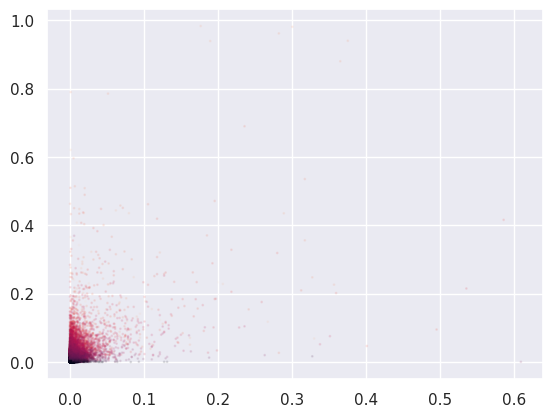

In [14]:
f, ax = plt.subplots()
ax.scatter(
    np.exp(mpt30b["logp_N_A"]),
    np.exp(mpt30b["clogp_N_A"]),
    s=1,
    alpha=0.1,
    c=mpt30b["clogp_AN"],
)

plt.show()

In [33]:
scipy.stats.pearsonr(np.exp(mpt30b["logp_N_A"]), np.exp(mpt30b["clogp_N_A"]))

PearsonRResult(statistic=0.509085828164952, pvalue=0.0)

In [30]:
scipy.stats.spearmanr(np.exp(mpt30b["logp_N_A"]), np.exp(mpt30b["clogp_N_A"]))

SpearmanrResult(correlation=0.4676093190834018, pvalue=0.0)

In [6]:
mpt30b.sample(4)

,adj_freq,adjective,arank,bayes_logp_N_A,clogp_A,clogp_A*N,clogp_AN,clogp_N,ecdf_logp_A,ecdf_logp_N,ecdf_logp_N_A,hybrid_logp_N_A,logp_A,logp_N,logp_N_A,model,noun,noun_freq,nrank,pair_freq
499469,12878,incredible,479,-23.593750,-7.907336,-15.754489,-15.942881,-7.847152,0.373,0.462,0.581872,-17.969836,-13.531250,-12.390625,-10.06250,mpt_30b,reality,40874,442,2.0
222784,31298,british,202,-25.148438,-7.019348,-15.271452,-15.655199,-8.252104,0.166,0.210,0.456459,-17.644348,-14.523438,-13.273438,-10.62500,mpt_30b,advice,27263,757,3.0
82297,85004,recent,62,-19.750000,-6.020224,-13.511110,-13.996971,-7.490886,0.928,0.860,0.750688,-15.207724,-10.562500,-11.062500,-9.18750,mpt_30b,race,58368,270,20.0
655302,8427,dynamic,635,-19.593750,-8.331375,-15.834968,-14.962052,-7.503593,0.756,0.491,0.926400,-15.987625,-11.937500,-12.359375,-7.65625,mpt_30b,leaders,57631,275,7.0


In [21]:
sm.OLS(
    np.exp(mpt30b["logp_N_A"]), sm.add_constant(np.exp(mpt30b["clogp_N_A"]))
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logp_N_A   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                 3.498e+05
Date:                Tue, 30 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:23:12   Log-Likelihood:             4.5776e+06
No. Observations:             1000000   AIC:                        -9.155e+06
Df Residuals:                  999998   BIC:                        -9.155e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.493e-05   2.52e-06     13.880      0.000       3e-05    3.99e-05
clogp_N_A      0.2254      0.000    591.467      0.000       0.225       0.226
==============================================================================
Omnibus:                  3661016.686   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    6024419288164.226
Skew:                          77.411   Prob(JB):                         0.00
Kurtosis:                   12026.398   Cond. No.                         153.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

                            OLS Regression Results                            
Dep. Variable:              clogp_N_A   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                 3.498e+05
Date:                Tue, 30 Jan 2024   Prob (F-statistic):               0.00
Time:                        19:29:59   Log-Likelihood:             3.7626e+06
No. Observations:             1000000   AIC:                        -7.525e+06
Df Residuals:                  999998   BIC:                        -7.525e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007   5.64e-06    124.188      0.0

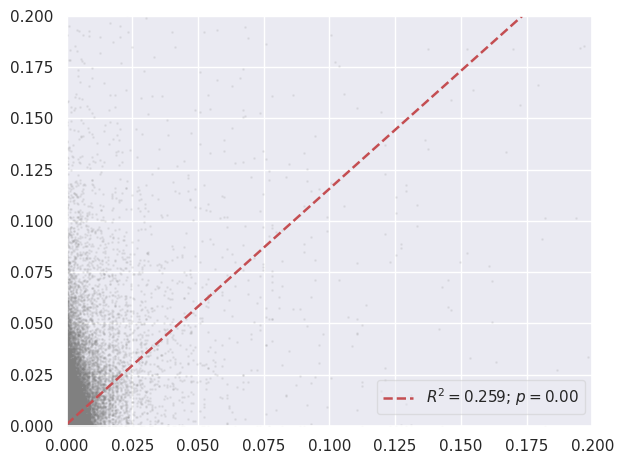

In [15]:
x, y, fit = compute_fit(
    mpt30b,
    metric=("logp_N_A"),
    target=("clogp_N_A"),
    # flip=True,
    logy=False,
    # normy=True,
    # normx=True,
)
print(fit.summary())

f, ax = plt.subplots(
    # figsize=(7, 5)
)
ax.scatter(
    x,
    y,
    alpha=0.1,
    s=1,
    c="gray",
)
# ax.set_yscale("log")
# ax.set_yscale("log")
# extract intercept b and slope m
b, m = fit.params
# plot y = m*x + b
ax.axline(
    xy1=(0, b),
    xy2=(1, m + b),
    color="r",
    linewidth=1.8,
    linestyle="--",
    # slope=m,
    # label=f"$y = {m:.1f}x {b:+.1f}$; $R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
    label=f"$R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 0.2)
# ax.set_ylim(1e-0, max(y) + 1)
ax.legend(loc="lower right", bbox_to_anchor=(1, 0.01), framealpha=0.5)
# ax.set_title("MPT-30B against observed frequency of 1M Adjective-Noun pairs in COCA")
# ax.set_ylabel(
#     "MPT-30B log probabilities (normed) augmented with\nCOCA priors: $\quad log\; \left(P_{MPT}(N|A)\cdot P_{COCA}(A)\\right)$"
# )
# ax.set_xlabel("COCA observed occurrences (log)")

plt.tight_layout()
plt.show()

In [20]:
models = {
    "gpt2xl": gpt2xl,
    "phi2": phi2,
    "mpt7b": mpt7b,
    "mpt7bchat": mpt7bchat,
    "Mistral-7B-v0.1": mistral7b,
    "mpt30b": mpt30b,
    "mpt30bchat": mpt30bchat,
}

In [39]:
def compute_corrs(x, y, model_name):
    pearsonr = scipy.stats.pearsonr(x, y)
    spearmanr = scipy.stats.spearmanr(x, y)

    result = {
        "model": model_name,
        "pearsonr": pearsonr.statistic,
        "pearsonr_p": pearsonr.pvalue,
        "pearsonr_ci": pearsonr.confidence_interval(0.95),
        "spearmanr": spearmanr.correlation,
        "spearmanr_p": spearmanr.pvalue,
        # "spearmanr_ci": spearmanr.confidence_interval(0.95),
    }
    return result

In [44]:
results = []
for model in list(models):  # + ["clogp_A", "clogp_N", "clogp_A*N"]:
    x, y = np.exp(models[model]["logp_N_A"]), np.exp(models[model]["clogp_N_A"])
    result = compute_corrs(x, y, model)
    print(model, result)
    results.append(result)

for baseline_col, name in [
    ("clogp_A", "P(A)"),
    ("clogp_N", "P(N)"),
    ("clogp_AN", "P(AN)"),
]:
    x, y = np.exp(models["gpt2xl"][baseline_col]), np.exp(models["gpt2xl"]["clogp_N_A"])
    result = compute_corrs(x, y, name)
    print(name, result)
    results.append(result)

    # try:
    #     x, y, fit = compute_fit(models[model], metric="logp_N_A")
    # except:
    #     continue

    # r2 = fit.rsquared
    # p = fit.pvalues[1]
    # # record std error
    # std = fit.bse[1]
    # # record ci
    # ci = fit.conf_int()[0][1], fit.conf_int()[1][1]
    # results.append(
    #     {"model": model, "r2": r2, "p": p, "std": std, "ci1": ci[0], "ci2": ci[1]}
    # )
    # print(
    #     model,
    #     f"{fit.rsquared=:.4f}, {fit.pvalues[1]=:.3f}; eqn: y = {fit.params[1]:.3f}x + {fit.params[0]:.3f}",
    # )

gpt2xl {'model': 'gpt2xl', 'pearsonr': 0.4768692107997883, 'pearsonr_p': 0.0, 'pearsonr_ci': ConfidenceInterval(low=0.4753535339891243, high=0.47838205701145303), 'spearmanr': 0.4281214777060275, 'spearmanr_p': 0.0}
phi2 {'model': 'phi2', 'pearsonr': 0.47696530897995526, 'pearsonr_p': 0.0, 'pearsonr_ci': ConfidenceInterval(low=0.4754498117054425, high=0.47847797542094206), 'spearmanr': 0.41093571286186203, 'spearmanr_p': 0.0}
mpt7b {'model': 'mpt7b', 'pearsonr': 0.4958404504097295, 'pearsonr_p': 0.0, 'pearsonr_ci': ConfidenceInterval(low=0.49436092058955333, high=0.49731710732002493), 'spearmanr': 0.42866718798282566, 'spearmanr_p': 0.0}
mpt7bchat {'model': 'mpt7bchat', 'pearsonr': 0.3699175388754419, 'pearsonr_p': 0.0, 'pearsonr_ci': ConfidenceInterval(low=0.3682245465408033, high=0.3716080780644182), 'spearmanr': 0.37741593764052794, 'spearmanr_p': 0.0}
Mistral-7B-v0.1 {'model': 'Mistral-7B-v0.1', 'pearsonr': 0.4586604920339626, 'pearsonr_p': 0.0, 'pearsonr_ci': ConfidenceInterval(lo

In [109]:
for metric in ["clogp_A", "clogp_N", "clogp_A*N"]:
    *_, fit = compute_fit(
        mpt7bchat,
        metric=metric,
    )
    print(
        f"{metric} {fit.rsquared=:.4f}, {fit.pvalues.to_list()[1]=:.3f}; eqn: y = {fit.params.to_list()[1]:.3f}x + {fit.params.to_list()[0]:.3f}"
    )
    # record std error
    std = fit.bse[1]
    # record ci
    ci = fit.conf_int()[0][1], fit.conf_int()[1][1]
    results.append(
        {
            "model": metric,
            "r2": fit.rsquared,
            "p": fit.pvalues.to_list()[1],
            "std": std,
            "ci1": ci[0],
            "ci2": ci[1],
        }
    )

clogp_A fit.rsquared=0.2088, fit.pvalues.to_list()[1]=0.000; eqn: y = 0.571x + 5.287
clogp_N fit.rsquared=0.0501, fit.pvalues.to_list()[1]=0.000; eqn: y = 0.442x + 4.288
clogp_A*N fit.rsquared=0.2559, fit.pvalues.to_list()[1]=0.000; eqn: y = 0.534x + 9.146


In [45]:
results = pd.DataFrame(results)
# results["model"] += results["p"].apply(lambda val: " (*)" if val < 0.05 else "")
results

,model,pearsonr,pearsonr_p,pearsonr_ci,spearmanr,spearmanr_p
0,gpt2xl,4.768692e-01,0.0,"(0.4753535339891243, 0.47838205701145303)",0.428121,0.0
1,phi2,4.769653e-01,0.0,"(0.4754498117054425, 0.47847797542094206)",0.410936,0.0
2,mpt7b,4.958405e-01,0.0,"(0.49436092058955333, 0.49731710732002493)",0.428667,0.0
3,mpt7bchat,3.699175e-01,0.0,"(0.3682245465408033, 0.3716080780644182)",0.377416,0.0
4,Mistral-7B-v0.1,4.586605e-01,0.0,"(0.4571114517266157, 0.46020674979759446)",0.390801,0.0
5,mpt30b,5.090858e-01,0.0,"(0.5076323743113922, 0.510536384425948)",0.467609,0.0
6,mpt30bchat,4.629811e-01,0.0,"(0.46143986194123504, 0.46451955067317946)",0.423243,0.0
7,P(A),-1.527998e-17,1.0,"(-0.0019599644147782445, 0.001959964414778214)",0.200375,0.0
8,P(N),1.229547e-01,0.0,"(0.12102385519153201, 0.12488452336078884)",0.222392,0.0
9,P(AN),4.010128e-01,0.0,"(0.39936669487691623, 0.40265625712006625)",0.946273,0.0


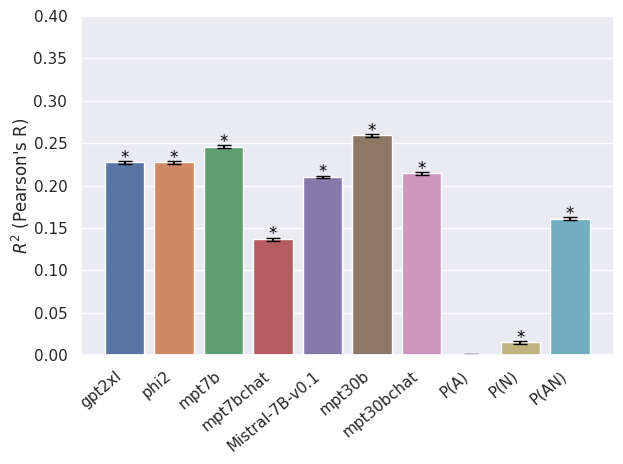

In [54]:
ax = sns.barplot(
    x=results["model"],
    y=results["pearsonr"] ** 2,
)
# ax.set_xlim(0, 0.1)
# rotate xaxis labels
plt.xticks(rotation=40, ha="right")
# plt.title(
#     "Observed frequency in COCA vs.\nModel predictions scaled to model marginals: $P_{model}(N|A)P_{model}(A)$"
# )
# plt.title("Observed frequency in COCA vs. Model predictions")
plt.ylabel("$R^2$ (Pearson's R)", rotation=90, labelpad=1)
plt.xlabel(None)

# place asterisk marking significance above each bar
for i, row in results.iterrows():
    ax.text(
        i,
        row["pearsonr"] ** 2 - 0.005,
        "*" if row["pearsonr_p"] < 0.05 else "",
        ha="center",
        va="bottom",
        color="black",
    )

# plot confidence intervals
ax.errorbar(
    x=results.index,
    y=results["pearsonr"] ** 2,
    yerr=results["pearsonr_ci"].apply(lambda x: x[1] - x[0]) / 2,
    fmt="none",
    c="black",
    capsize=5,
)

# plot error bars
# ax.errorbar(
#     x=results.index,
#     y=results["r2"],
#     yerr=results["std"],
#     fmt="none",
#     c="black",
#     capsize=5,
# )
ax.set_ylim(0, 0.4)

plt.tight_layout()
plt.show()

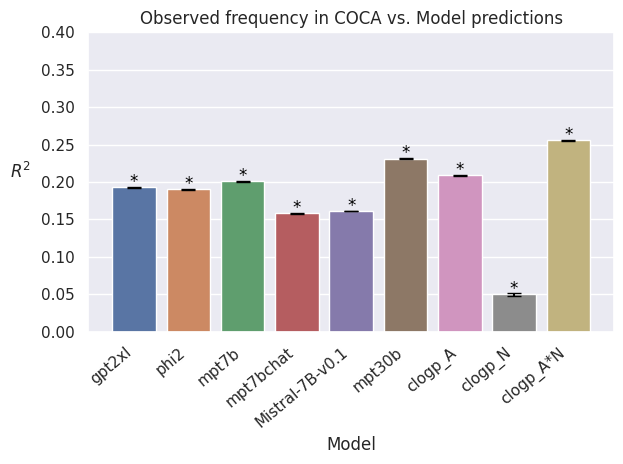

In [112]:
ax = sns.barplot(
    x=results["model"],
    y=results["r2"],
)
# ax.set_xlim(0, 0.1)
# rotate xaxis labels
plt.xticks(rotation=40, ha="right")
# plt.title(
#     "Observed frequency in COCA vs.\nModel predictions scaled to model marginals: $P_{model}(N|A)P_{model}(A)$"
# )
plt.title("Observed frequency in COCA vs. Model predictions")
plt.ylabel("$R^2$", rotation=0, labelpad=15)
plt.xlabel("Model")

# place asterisk marking significance above each bar
for i, row in results.iterrows():
    ax.text(
        i,
        row["r2"] - 0.005,
        "*" if row["p"] < 0.05 else "",
        ha="center",
        va="bottom",
        color="black",
    )
# plot error bars
ax.errorbar(
    x=results.index,
    y=results["r2"],
    yerr=results["std"],
    fmt="none",
    c="black",
    capsize=5,
)
ax.set_ylim(0, 0.4)

plt.tight_layout()
plt.show()

## Construct adjacency matrix

In [87]:
mpt30b

,adj_freq,adjective,arank,bayes_logp_N_A,clogp_A,clogp_A*N,clogp_AN,clogp_N,ecdf_logp_A,ecdf_logp_N,ecdf_logp_N_A,hybrid_logp_N_A,logp_A,logp_N,logp_N_A,model,noun,noun_freq,nrank,pair_freq
20027,738678,other,0,-12.453125,-3.858071,-8.703068,-7.107477,-4.844997,0.951,0.994,0.999890,-6.061196,-10.250000,-7.937500,-2.203125,mpt_30b,people,822767,0,20619.0
20028,738678,other,0,-18.187500,-3.858071,-8.715697,-9.869837,-4.857626,0.951,0.972,0.906357,-11.795571,-10.250000,-9.812500,-7.937500,mpt_30b,time,812441,1,1301.0
20029,738678,other,0,-19.437500,-3.858071,-9.089532,-11.364740,-5.231461,0.951,0.724,0.750688,-13.045571,-10.250000,-11.625000,-9.187500,mpt_30b,years,559033,2,291.0
20030,738678,other,0,-19.687500,-3.858071,-9.201974,-11.200852,-5.343903,0.951,0.817,0.709193,-13.295571,-10.250000,-11.250000,-9.437500,mpt_30b,year,499579,3,343.0
20031,738678,other,0,-17.437500,-3.858071,-9.218762,-8.090961,-5.360691,0.951,0.848,0.953025,-11.045571,-10.250000,-11.125000,-7.187500,mpt_30b,way,491262,4,7711.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020022,4504,unfamiliar,999,-23.644531,-8.957747,-17.465671,0.000000,-8.507924,0.158,0.672,0.772275,-18.020247,-14.582031,-11.796875,-9.062500,mpt_30b,beer,21109,995,0.0
1020023,4504,unfamiliar,999,-25.144531,-8.957747,-17.466713,0.000000,-8.508967,0.158,0.490,0.471808,-19.520247,-14.582031,-12.375000,-10.562500,mpt_30b,option,21087,996,0.0
1020024,4504,unfamiliar,999,-23.644531,-8.957747,-17.467045,-16.348346,-8.509299,0.158,0.834,0.772275,-18.020247,-14.582031,-11.187500,-9.062500,mpt_30b,key,21080,997,1.0
1020025,4504,unfamiliar,999,-24.644531,-8.957747,-17.468802,0.000000,-8.511055,0.158,0.631,0.581872,-19.020247,-14.582031,-11.937500,-10.062500,mpt_30b,exchange,21043,998,0.0


In [84]:
def construct_mat(df, col="corpus_logp_N_A"):
    mat = np.zeros((1000, 1000))
    for i, row in tqdm(df.iterrows(), total=len(df)):
        mat[row.loc["arank"], row.loc["nrank"]] = row.loc[col]
    return mat

In [85]:
mat_mpt30b = construct_mat(mpt30b, col="logp_N_A")
mat_mpt30b_hybrid = construct_mat(mpt30b, col="hybrid_logp_N_A")

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [88]:
mat_mpt30b_bayes = construct_mat(mpt30b, col="bayes_logp_N_A")

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [86]:
pd.to_pickle(mat_mpt30b, "./simulate-comb-A-N/mat_mpt30b.pkl")
pd.to_pickle(mat_mpt30b_hybrid, "./simulate-comb-A-N/mat_mpt30b_hybrid.pkl")

In [89]:
pd.to_pickle(mat_mpt30b_bayes, "./simulate-comb-A-N/mat_mpt30b_bayes.pkl")